In [190]:
import string
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from helpers.load_data import load_data
from model_comparison import *

%config InlineBackend.figure_format = 'retina'
sns.set_palette('colorblind')

df, const = load_data()

matplotlib.rcParams.update({'font.size': 17})

# Figure 1

/tmp/ipykernel_211160/3982707664.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_df['reward'] = np.where(
/tmp/ipykernel_211160/3982707664.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_df['regret'] = rand_df['MaxReward'] - rand_df['reward']
/tmp/ipykernel_211160/3982707664.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

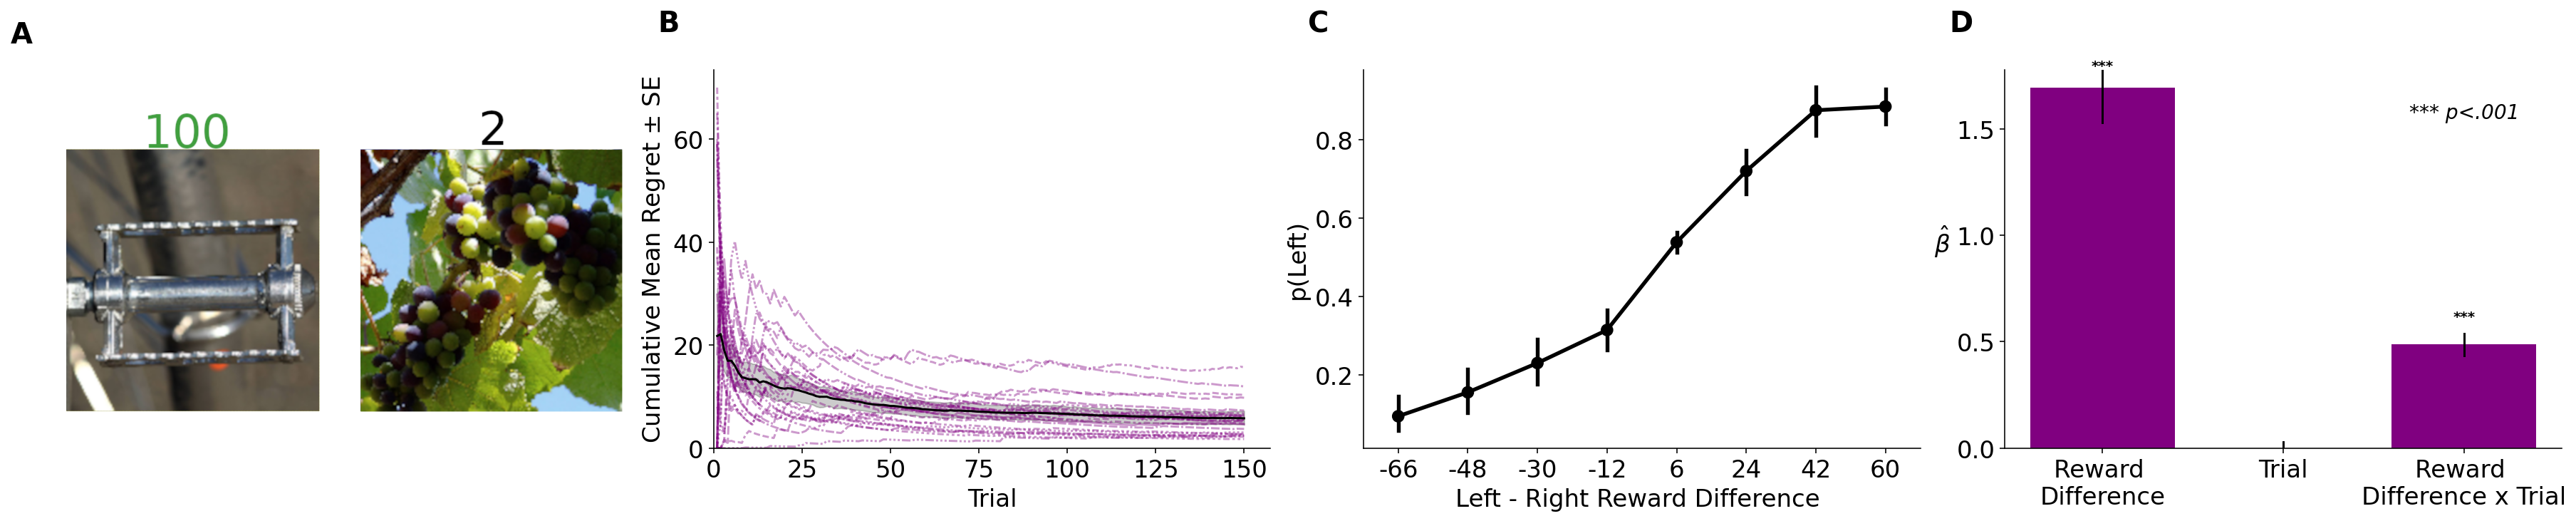

In [191]:
mosaic = """
    ABCD
    """

fig1 = plt.figure(constrained_layout=True, figsize=(25, 5))
ax_dict = fig1.subplot_mosaic(mosaic)


#########################################################
task = mpimg.imread('../../figures/task_design.png')

ax_dict['A'].spines['top'].set_visible(False)
ax_dict['A'].spines['right'].set_visible(False)
ax_dict['A'].spines['bottom'].set_visible(False)
ax_dict['A'].spines['left'].set_visible(False)

ax_dict['A'].imshow(task)
ax_dict['A'].get_xaxis().set_ticks([])
ax_dict['A'].get_yaxis().set_ticks([])


ax_dict['A'].text(-0.1, 1.2, string.ascii_uppercase[0], transform=ax_dict['A'].transAxes,
                  size=20, weight='bold')
##########################################################

df['reward'] = np.where(df['responseKey'] == 'left',
                        df['RewardLeft'], df['RewardRight'])
df['regret'] = df['MaxReward'] - df['reward']
all_df = pd.read_csv('../../data/humans_and_models.csv')
rand_df = all_df[all_df['agent'] == 'Rand']


def mean_regret(df):

    return np.cumsum(df['regret'])/range(1, const['trials']+1)


df['mean regret'] = df.groupby('participant_n').apply(mean_regret).values
rand_df['reward'] = np.where(
    rand_df['choice_history'] == 0, rand_df['RewardLeft'], rand_df['RewardRight'])
rand_df['regret'] = rand_df['MaxReward'] - rand_df['reward']

rand_df['mean regret'] = rand_df.groupby(
    'participant_n').apply(mean_regret).values


sns.lineplot(data=df, x='trial_n', y='mean regret', color='purple',
             style='participant_n', ax=ax_dict['B'], alpha=.4)
sns.lineplot(data=df, x='trial_n', y='mean regret', color='k', ax=ax_dict['B'])


ax_dict['B'].set(ylabel=r'Cumulative Mean Regret $\pm$ SE', xlabel='Trial')


ax_dict['B'].text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax_dict['B'].transAxes,
                  size=20, weight='bold')
ax_dict['B'].legend([], [], frameon=False)
ax_dict['B'].set_ylim(ymin=0)
ax_dict['B'].set_xlim(xmin=0)

##########################################################

# Initialise bin variables
step = 18
df['RewardDiffLR'] = df['RewardLeft'] - df['RewardRight']
minVal = round(min(df['RewardDiffLR']))
maxVal = round(max(df['RewardDiffLR']))
bins = np.arange(minVal, maxVal, step)  # end element otherwise not included

# Calculate total count of responses
total_count = df.groupby(['participant_n', pd.cut(
    df['RewardDiffLR'], bins)]).agg({'responseKey': 'count'})
# Calculate count of left vs right responses, for each bin
response_count = df.groupby(['participant_n', 'responseKey', pd.cut(
    df['RewardDiffLR'], bins)]).agg({'responseKey': 'count'})

# Calculate probability of left/right choice for each bin
allCounts = response_count.div(total_count)
allCounts = allCounts.add_suffix('_').reset_index().rename(
    columns={'responseKey_': 'PCorrectChoice'})
allCounts.RewardDiffLR = allCounts.RewardDiffLR.astype(str)

sns.pointplot(data=allCounts[allCounts['responseKey'] == 'left'], x='RewardDiffLR',
              y='PCorrectChoice', color='k', ax=ax_dict['C'])
ax_dict['C'].set(
    xlabel='Left - Right Reward Difference ',
    ylabel='p(Left)')

ax_dict['C'].set_xticklabels([str(x) for x in range(-66,61,18)])

ax_dict['C'].text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax_dict['C'].transAxes,
                  size=20, weight='bold')
##########################################################
trial_feature_df = pd.read_csv('../../models/trial_reward_effects.csv')
trial_feature_df = trial_feature_df[trial_feature_df['effect']=='fixed']
trial_feature_df = trial_feature_df.replace(['RewardDiffRightLeft', 'trial_n', 'RewardDiffRightLeft:trial_n'],
                                            ['Reward Difference', 'Trial', 'Reward Difference x Trial'])
ax_dict['D'].bar(trial_feature_df['term'],trial_feature_df['estimate'],color='purple')
ax_dict['D'].set_ylabel(r'$\hat{\beta}$',rotation=0,labelpad=10)
#ax_dict['D'].set_ylim([-.3, 2])
ax_dict['D'].set_xticklabels(['Reward \nDifference','Trial','Reward \nDifference x Trial'])
ax_dict['D'].set_ylim(ymin=0)


for regressor in trial_feature_df['term'].values:

    ax_dict['D'].plot([regressor,regressor],
    [float(trial_feature_df[trial_feature_df['term']==regressor]['estimate'] + trial_feature_df[trial_feature_df['term']==regressor]['std.error']),
    float(trial_feature_df[trial_feature_df['term']==regressor]['estimate'] - trial_feature_df[trial_feature_df['term']==regressor]['std.error'])],
    color='k')

ax_dict['D'].annotate('***',
                      xy=('Reward Difference', 1.78),
                      fontsize=10, weight='bold',ha='center')
ax_dict['D'].annotate('***',
                      xy=('Reward Difference x Trial', .6),
                      fontsize=10, weight='bold',ha='center')

ax_dict['D'].annotate('*** p<.001',
                    xy=('Reward Difference x Trial',1.55),
                    fontsize=14, style='italic',ha='center')


ax_dict['D'].text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax_dict['D'].transAxes,
                  size=20, weight='bold')



for ax in ax_dict.values():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig('../../figures/figure1.png')

# Figure 2

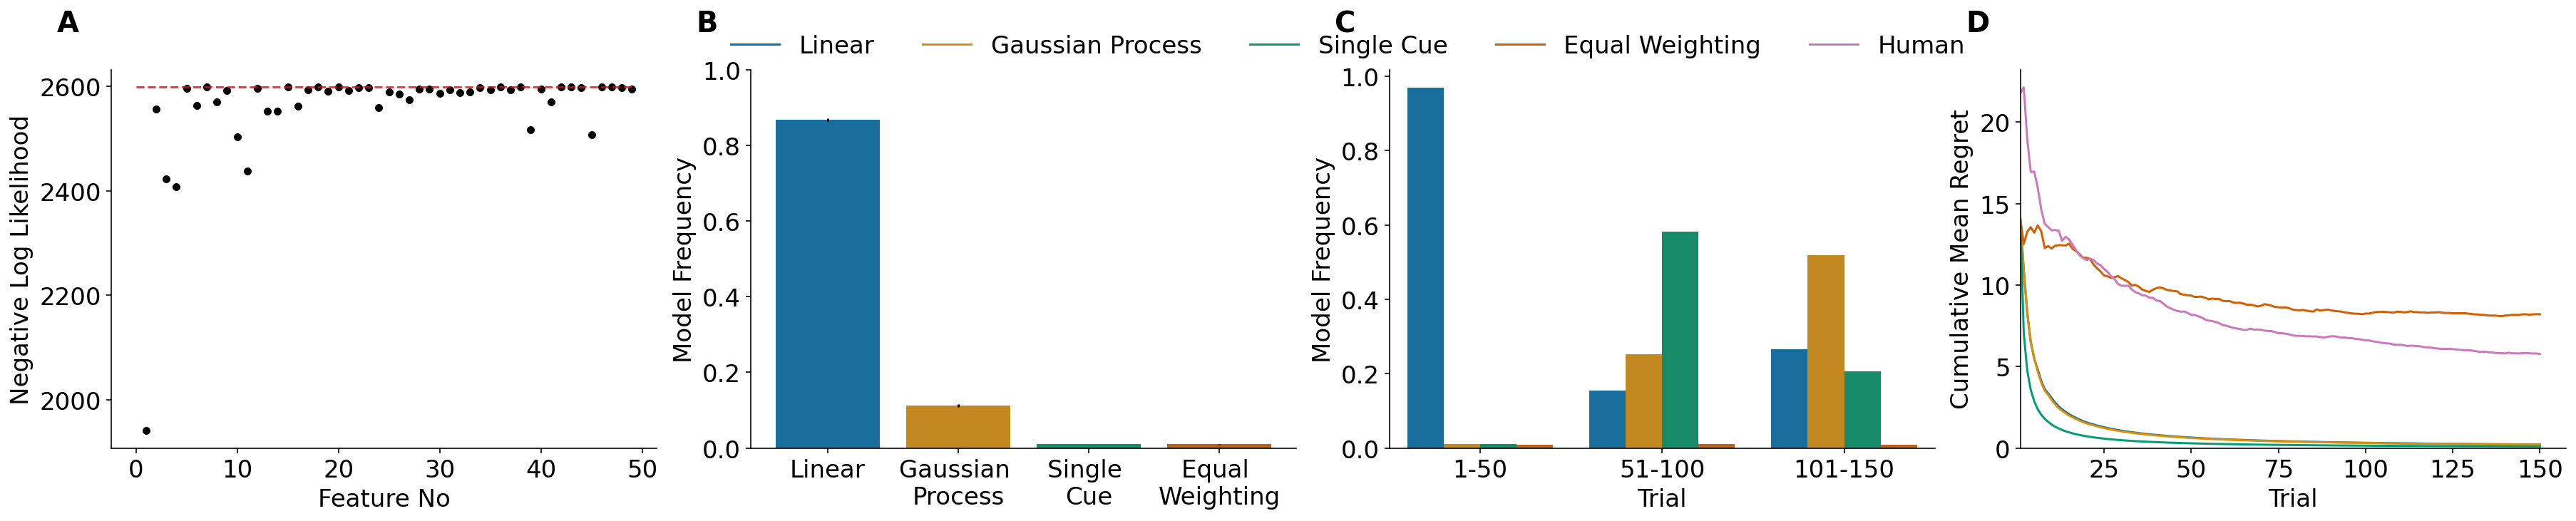

In [192]:
#TODO: add error bars and p_exc to the binned model frequency
#TODO: label some latent dims in fig2a
mosaic = """
    ABCD
    """

fig2 = plt.figure(constrained_layout=True, figsize=(25, 5))
ax2_dict = fig2.subplot_mosaic(mosaic)


#########################################################

feature_logl_df = pd.read_csv('../../models/loglike_by_feature.csv')
feature_logl_df['negloglik'] = - feature_logl_df['loglik']
rand_negloglik = -np.log(.5) * const['trials'] * const['par']
ax2_dict['A'].hlines(rand_negloglik,
                     xmin=0, xmax=49, color='r', alpha=.8, linestyles='dashed')
sns.scatterplot(data=feature_logl_df, x='feature_no',
                y='negloglik', color='k', ax=ax2_dict['A'])

ax2_dict['A'].set(ylabel=r'Negative Log Likelihood', xlabel='Feature No')
ax2_dict['A'].text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax2_dict['A'].transAxes,
                   size=20, weight='bold')

#########################################################

model_freq_df = pd.read_csv('../../models/model_frequency.csv')
model_freq_df['low'] = model_freq_df['mean'] - model_freq_df['var']
model_freq_df['high'] = model_freq_df['mean'] + model_freq_df['var']

sns.barplot(data=model_freq_df, x='model', y='mean',
            hue='model', ax=ax2_dict['B'], dodge=False)
ax2_dict['B'].legend([], [], frameon=False)
ax2_dict['B'].set(ylabel=r'Model Frequency',xlabel='Agent')

for model in model_freq_df['model'].unique():
    ax2_dict['B'].vlines(x=model,ymin=model_freq_df[model_freq_df['model']==model]['low'].values[0],
    ymax=model_freq_df[model_freq_df['model']==model]['high'].values[0],color='k')

ax2_dict['B'].set_xticklabels(['Linear','Gaussian \nProcess','Single \nCue','Equal \nWeighting'])
ax2_dict['B'].set_xlabel(None)
# ax2_dict['B'].hlines(xmin=-.5,xmax=3.5,y=.95,color='k')
# ax2_dict['B'].vlines(ymin=.90,ymax=.95,x=0,color='k')
# ax2_dict['B'].annotate('XP > .99',
#                       xy=(.85, 1),
#                       fontsize=14, weight='bold',ha='center')
ax2_dict['B'].text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2_dict['B'].transAxes,
                   size=20, weight='bold')
ax2_dict['B'].set_ylim([0,1])
#########################################################
binned_loo = pd.read_csv('../../models/model_frequency_binned.csv')
binned_loo = binned_loo.replace(['FRL','GP','SingleCue','EqualWeight'],
                                            ['Linear', 'Gaussian \nProcess', 'Single \nCue','Equal \nWeighting'])
binned_loo['low'] = binned_loo['mean'] - binned_loo['var']
binned_loo['high'] = binned_loo['mean'] + binned_loo['var']

sns.barplot(data=binned_loo, x='bin', y='mean',
            hue='model', ax=ax2_dict['C'])
ax2_dict['C'].set(ylabel='Model Frequency',xlabel='Agent')
ax2_dict['C'].set_xticklabels(['1-50','51-100','101-150'])
ax2_dict['C'].set_xlabel('Trial')
ax2_dict['C'].legend([], [], frameon=False)

ax2_dict['C'].text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax2_dict['C'].transAxes,
                   size=20, weight='bold')


#########################################################

all_df = pd.read_csv('../../data/humans_and_models.csv')
#choice_df = pd.read_csv('../../models/choice_probs.csv')
all_df = all_df[all_df['agent'] != "Rand"]
all_df = all_df[all_df['agent'] != "human"]
all_df['value_rl_diff'] = all_df['value_right'] - all_df['value_left']
all_df['choice_history'] = np.where(all_df['value_rl_diff']>0,1,0)
all_df['reward'] = np.where(all_df['choice_history'] ==
                            0, all_df['RewardLeft'], all_df['RewardRight'])

all_df['regret'] = all_df['MaxReward'] - all_df['reward']
# i hate pandas and myself so I will do cumulative mean regret manually, lets go!

agents = []
regrets = []
mean_regrets = []
participants = []
trials = []

frl_regret = all_df.loc[all_df['agent']=='FRL','regret'].to_list()
regrets.extend(frl_regret)
frl_cum_regret = []
i = 0
for _ in range(25):
    frl_cum_regret.extend(np.cumsum(frl_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(frl_cum_regret)
agents.extend(['FRL']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
gp_regret = all_df.loc[all_df['agent']=='GP','regret'].to_list()
regrets.extend(gp_regret)
gp_cum_regret = []
i = 0
for _ in range(25):
    gp_cum_regret.extend(np.cumsum(gp_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(gp_cum_regret)
agents.extend(['GP']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)

sc_regret = all_df.loc[all_df['agent']=='SingleCue','regret'].to_list()
regrets.extend(sc_regret)
sc_cum_regret = []
i = 0
for _ in range(25):
    sc_cum_regret.extend(np.cumsum(sc_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(sc_cum_regret)
agents.extend(['SingleCue']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
ew_regret = all_df.loc[all_df['agent']=='EqualWeight','regret'].to_list()
regrets.extend(ew_regret)
ew_cum_regret = []
i = 0
for _ in range(25):
    ew_cum_regret.extend(np.cumsum(ew_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(ew_cum_regret)
agents.extend(['EqualWeight']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
h_regret = df['regret'].to_list()
regrets.extend(h_regret)
h_cum_regret = df['mean regret'].to_list()
mean_regrets.extend(h_cum_regret)
agents.extend(['human']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
all_regrets = {'agent':agents,'regret':regrets,'mean_regret':mean_regrets,'participant_n':participants,'trial_n':trials}
all_df = pd.DataFrame(data=all_regrets)
all_df['mean regret'] = all_df['mean_regret']
sns.lineplot(data=all_df, x='trial_n', y='mean regret',
             hue='agent', ax=ax2_dict['D'],ci=None)

ax2_dict['D'].legend(labels=['Linear','Gaussian \nProcess','Single \nCue','Equal \nWeighting','Human'],loc='upper center', bbox_to_anchor=(0.7, 1.2),
          ncol=2, frameon=False)
ax2_dict['D'].set(ylabel=r'Cumulative Mean Regret', xlabel='Trial')
ax2_dict['D'].text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax2_dict['D'].transAxes,
                   size=20, weight='bold')
ax2_dict['D'].set_ylim(ymin=0)
ax2_dict['D'].set_xlim(xmin=1)

handles, labels = ax2_dict['D'].get_legend_handles_labels()
fig2.legend(handles, ['Linear','Gaussian Process','Single Cue','Equal Weighting','Human'], loc=(.28,.87),ncol=5,frameon=False)
ax2_dict['D'].legend([], [], frameon=False)

for ax in ax2_dict.values():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)



plt.savefig('../../figures/figure2.png')


# Figure 3

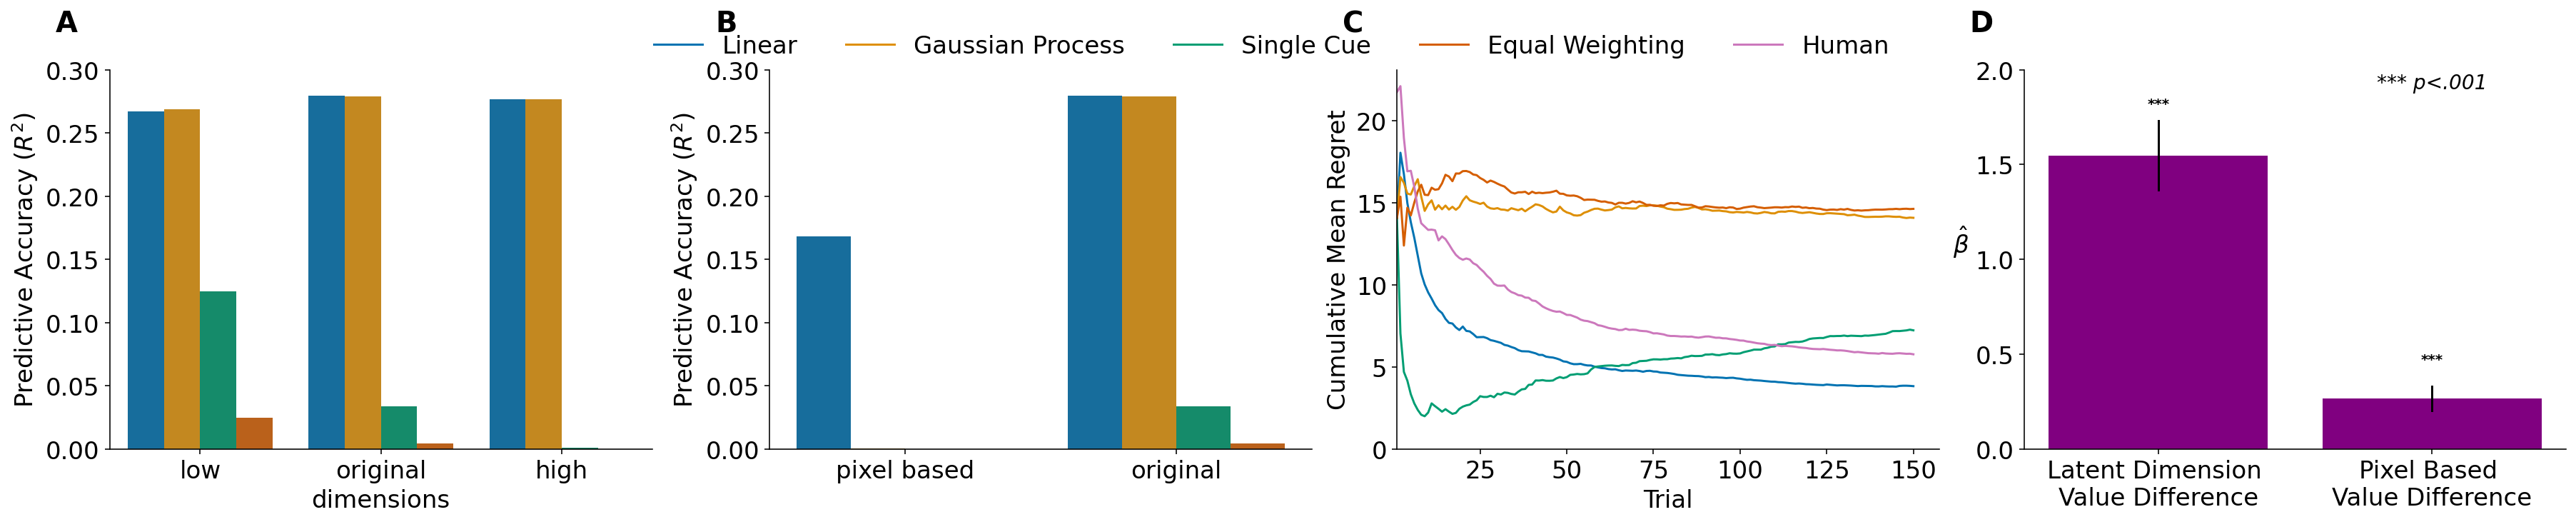

In [180]:
#TODO:add legends
mosaic = """
    ABCD
    """

fig3 = plt.figure(constrained_layout=True, figsize=(25, 5))
ax3_dict = fig3.subplot_mosaic(mosaic)

#########################################################

models_og = pd.read_csv('../../models/loo.csv')
models_14 = pd.read_csv('../../models/loo_14.csv')
models_82 = pd.read_csv('../../models/loo_82.csv')

fit_og = r_squared(models_og,const)
fit_og['dimensions'] = 'original'

fit_14 = r_squared(models_14,const)
fit_14['dimensions'] = 'low'

fit_82 = r_squared(models_82,const)
fit_82['dimensions'] = 'high'

fits = [fit_14,fit_og,fit_82]
fits_df = pd.concat(fits,ignore_index=True)

fits_df = pd.melt(fits_df,id_vars='dimensions',value_vars=['FRL','GP','SingleCue','EqualWeight'])
fits_df['agent'] = fits_df['variable']
fits_df['r2'] = fits_df['value']
sns.barplot(data=fits_df, x='dimensions', y='value',
             hue='agent', ax=ax3_dict['A'],ci=None)
ax3_dict['A'].set(ylabel=r'Predictive Accuracy ($R^2$)')
ax3_dict['A'].margins(y=0)
ax3_dict['A'].legend([], [], frameon=False)
ax3_dict['A'].set_ylim([0,.3])
ax3_dict['A'].text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax3_dict['A'].transAxes,
                   size=20, weight='bold')

#########################################################

models_resnet = pd.read_csv('../../models/loo_resnet.csv')
fit_resnet = r_squared(models_resnet,const)
fit_resnet['dimensions'] = 'pixel based'
fit_og['dimensions'] = 'original'
og_vs_resnet = pd.concat([fit_resnet,fit_og],ignore_index=True)
og_vs_resnet = pd.melt(og_vs_resnet,id_vars='dimensions',value_vars=['FRL','GP','SingleCue','EqualWeight'])
og_vs_resnet['agent'] = og_vs_resnet['variable']
og_vs_resnet['r2'] = og_vs_resnet['value']
sns.barplot(data=og_vs_resnet, x='dimensions', y='value',
             hue='agent', ax=ax3_dict['B'],ci=None,dodge=True)
ax3_dict['B'].set(ylabel=r'Predictive Accuracy ($R^2$)')
ax3_dict['B'].margins(y=0)
ax3_dict['B'].set_xlabel(None)
ax3_dict['B'].set_ylim([0,.3])

ax3_dict['B'].legend([], [], frameon=False)
ax3_dict['B'].text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax3_dict['B'].transAxes,
                   size=20, weight='bold')


#########################################################
all_df = pd.read_csv('../../data/humans_and_models_resnet.csv')
all_df = all_df[all_df['agent'] != "Rand"]
all_df = all_df[all_df['agent'] != "human"]
all_df['value_rl_diff'] = all_df['value_right'] - all_df['value_left']
all_df['choice_history'] = np.where(all_df['value_rl_diff']>0,1,0)
all_df['reward'] = np.where(all_df['choice_history'] ==
                            0, all_df['RewardLeft'], all_df['RewardRight'])

all_df['regret'] = all_df['MaxReward'] - all_df['reward']
# i hate pandas and myself so I will do cumulative mean regret manually, lets go!

agents = []
regrets = []
mean_regrets = []
participants = []
trials = []

frl_regret = all_df.loc[all_df['agent']=='FRL','regret'].to_list()
regrets.extend(frl_regret)
frl_cum_regret = []
i = 0
for _ in range(25):
    frl_cum_regret.extend(np.cumsum(frl_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(frl_cum_regret)
agents.extend(['FRL']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
gp_regret = all_df.loc[all_df['agent']=='GP','regret'].to_list()
regrets.extend(gp_regret)
gp_cum_regret = []
i = 0
for _ in range(25):
    gp_cum_regret.extend(np.cumsum(gp_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(gp_cum_regret)
agents.extend(['GP']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)

sc_regret = all_df.loc[all_df['agent']=='SingleCue','regret'].to_list()
regrets.extend(sc_regret)
sc_cum_regret = []
i = 0
for _ in range(25):
    sc_cum_regret.extend(np.cumsum(sc_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(sc_cum_regret)
agents.extend(['SingleCue']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
ew_regret = all_df.loc[all_df['agent']=='EqualWeight','regret'].to_list()
regrets.extend(ew_regret)
ew_cum_regret = []
i = 0
for _ in range(25):
    ew_cum_regret.extend(np.cumsum(ew_regret[i:i+150])/range(1,151))
    i+= 150
mean_regrets.extend(ew_cum_regret)
agents.extend(['EqualWeight']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
h_regret = df['regret'].to_list()
regrets.extend(h_regret)
h_cum_regret = df['mean regret'].to_list()
mean_regrets.extend(h_cum_regret)
agents.extend(['human']*25*150)
participants.extend([x for x in range(1,26) for _ in range(150)])
trials.extend(list(range(1,151)) * 25)
all_regrets = {'agent':agents,'regret':regrets,'mean_regret':mean_regrets,'participant_n':participants,'trial_n':trials}
all_df = pd.DataFrame(data=all_regrets)
all_df['mean regret'] = all_df['mean_regret']



sns.lineplot(data=all_df, x='trial_n', y='mean regret',
             hue='agent', ax=ax3_dict['C'],ci=None)
h, l = ax3_dict['C'].get_legend_handles_labels()
ax3_dict['C'].set(ylabel=r'Cumulative Mean Regret', xlabel='Trial')
ax3_dict['C'].legend(h,['Linear','Gaussian \nProcess','Single \nCue','Equal \nWeighting','Human'],ncol=2,frameon=False)
ax3_dict['C'].set_ylim(ymin=0)
ax3_dict['C'].set_xlim(xmin=1)
ax3_dict['C'].text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax3_dict['C'].transAxes,
                   size=20, weight='bold')

handles, labels = ax3_dict['C'].get_legend_handles_labels()
fig3.legend(handles, ['Linear','Gaussian Process','Single Cue','Equal Weighting','Human'], loc=(.25,.87),ncol=5,frameon=False)
ax3_dict['C'].legend([], [], frameon=False)
#########################################################

resnet_feature_df = pd.read_csv('../../models/resnet_and_latent_estimate.csv')
resnet_feature_df = resnet_feature_df[resnet_feature_df['effect']=='fixed']
resnet_feature_df = resnet_feature_df.replace(['ogrl', 'ValueDiffRightLeft'],
                                            ['Latent Dimension \nValue Difference', 'Pixel Based \nValue Difference'])
ax3_dict['D'].bar(resnet_feature_df['term'],resnet_feature_df['estimate'],color='purple')
ax3_dict['D'].set_ylabel(r'$\hat{\beta}$',rotation=0,labelpad=10)


for regressor in resnet_feature_df['term'].values:

    ax3_dict['D'].plot([regressor,regressor],
    [float(resnet_feature_df[resnet_feature_df['term']==regressor]['estimate'] + resnet_feature_df[resnet_feature_df['term']==regressor]['std.error']),
    float(resnet_feature_df[resnet_feature_df['term']==regressor]['estimate'] - resnet_feature_df[resnet_feature_df['term']==regressor]['std.error'])],
    color='k')

ax3_dict['D'].set_ylim([0,2])


ax3_dict['D'].annotate('***',
                       xy=('Latent Dimension \nValue Difference', 1.8),
                       fontsize=10, weight='bold',ha='center')
ax3_dict['D'].annotate('***',
                       xy=('Pixel Based \nValue Difference', .45),
                       fontsize=10, weight='bold',ha='center')

ax3_dict['D'].annotate('*** p<.001',
                    xy=('Pixel Based \nValue Difference',1.9),
                    fontsize=14, style='italic',ha='center')


ax3_dict['D'].text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax3_dict['D'].transAxes,
                  size=20, weight='bold')


for ax in ax3_dict.values():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig('../../figures/figure3.png')